In [49]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

bot_paths = [
    'data/social_spambots_1.csv',
    'data/social_spambots_2.csv',
    'data/social_spambots_3.csv'
]

bot_accounts = pd.concat([pd.read_csv(path) for path in bot_paths], ignore_index=True)
clean_accounts = pd.read_csv('data/geniune_accounts.csv')

In [50]:
REQUIRED_COLUMNS = [
    'screen_name', 'created_at', 'updated', 'location', 'verified',
    'statuses_count', 'friends_count', 'followers_count', 'favourites_count',
    'default_profile_image', 'profile_use_background_image',
    'protected', 'default_profile'
]

raw_bot_accounts = pd.concat([
    pd.read_csv('data/social_spambots_1.csv'),
    pd.read_csv('data/social_spambots_2.csv'),
    pd.read_csv('data/social_spambots_3.csv')
], ignore_index=True)

raw_clean_accounts = pd.read_csv('data/geniune_accounts.csv')

print("Raw Bot Columns:", raw_bot_accounts.columns)
print("Raw Clean Columns:", raw_clean_accounts.columns)

def clean_df(df):
    df['created_at'] = pd.to_datetime(df['created_at'], utc=True, errors='coerce')
    df['updated'] = pd.to_datetime(df['updated'], utc=True, errors='coerce')
    df['age'] = (df['updated'] - df['created_at']).dt.days

    df['has_location'] = df['location'].notna().astype(int)
    df['has_avatar'] = df['default_profile_image'].notna().astype(int)
    df['has_background'] = df['profile_use_background_image'].notna().astype(int)
    df['is_verified'] = df['verified'].notna().astype(int)
    df['is_protected'] = df['protected'].notna().astype(int)
    df['profile_modified'] = df['default_profile'].notna().astype(int)

    df = df.rename(columns={
        "screen_name": "username",
        "statuses_count": "total_tweets",
        "friends_count": "total_following",
        "followers_count": "total_followers",
        "favourites_count": "total_likes"
    })

    return df[[
        'username', 'age', 'has_location', 'is_verified',
        'total_tweets', 'total_following', 'total_followers', 'total_likes',
        'has_avatar', 'has_background', 'is_protected', 'profile_modified'
    ]]

bot_accounts = clean_df(raw_bot_accounts)
clean_accounts = clean_df(raw_clean_accounts)

print("Cleaned Bot Accounts Columns:", bot_accounts.columns)
print("Cleaned Clean Accounts Columns:", clean_accounts.columns)


Raw Bot Columns: Index(['id', 'name', 'screen_name', 'statuses_count', 'followers_count',
       'friends_count', 'favourites_count', 'listed_count', 'url', 'lang',
       'time_zone', 'location', 'default_profile', 'default_profile_image',
       'geo_enabled', 'profile_image_url', 'profile_banner_url',
       'profile_use_background_image', 'profile_background_image_url_https',
       'profile_text_color', 'profile_image_url_https',
       'profile_sidebar_border_color', 'profile_background_tile',
       'profile_sidebar_fill_color', 'profile_background_image_url',
       'profile_background_color', 'profile_link_color', 'utc_offset',
       'is_translator', 'follow_request_sent', 'protected', 'verified',
       'notifications', 'description', 'contributors_enabled', 'following',
       'created_at', 'timestamp', 'crawled_at', 'updated', 'test_set_1',
       'test_set_2'],
      dtype='object')
Raw Clean Columns: Index(['id', 'name', 'screen_name', 'statuses_count', 'followers_count'

<ipython-input-50-83ba92fe74d3>:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['created_at'] = pd.to_datetime(df['created_at'], utc=True, errors='coerce')
<ipython-input-50-83ba92fe74d3>:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['created_at'] = pd.to_datetime(df['created_at'], utc=True, errors='coerce')


Cleaned Bot Accounts Columns: Index(['username', 'age', 'has_location', 'is_verified', 'total_tweets',
       'total_following', 'total_followers', 'total_likes', 'has_avatar',
       'has_background', 'is_protected', 'profile_modified'],
      dtype='object')
Cleaned Clean Accounts Columns: Index(['username', 'age', 'has_location', 'is_verified', 'total_tweets',
       'total_following', 'total_followers', 'total_likes', 'has_avatar',
       'has_background', 'is_protected', 'profile_modified'],
      dtype='object')


In [51]:
# Load RAW datasets
raw_bot_accounts = pd.concat([
    pd.read_csv('data/social_spambots_1.csv'),
    pd.read_csv('data/social_spambots_2.csv'),
    pd.read_csv('data/social_spambots_3.csv')
], ignore_index=True)

raw_clean_accounts = pd.read_csv('data/geniune_accounts.csv')

# Clean data
bot_accounts = clean_df(raw_bot_accounts)
clean_accounts = clean_df(raw_clean_accounts)

# Labels
bot_accounts['BotOrNot'] = 1
clean_accounts['BotOrNot'] = 0

combined_df = pd.concat([bot_accounts, clean_accounts], ignore_index=True)


<ipython-input-50-83ba92fe74d3>:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['created_at'] = pd.to_datetime(df['created_at'], utc=True, errors='coerce')
<ipython-input-50-83ba92fe74d3>:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['created_at'] = pd.to_datetime(df['created_at'], utc=True, errors='coerce')


In [52]:
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)
train_size = int(0.8 * len(combined_df))

train_df = combined_df.iloc[:train_size].drop('username', axis=1)
test_df = combined_df.iloc[train_size:].drop('username', axis=1)

columns_to_scale = ['age', 'total_tweets', 'total_following', 'total_followers', 'total_likes']
mean_vals = train_df[columns_to_scale].mean()
std_vals = train_df[columns_to_scale].std()

train_df[columns_to_scale] = (train_df[columns_to_scale] - mean_vals) / std_vals
test_df[columns_to_scale] = (test_df[columns_to_scale] - mean_vals) / std_vals

In [53]:
X_train = train_df.drop(['BotOrNot', 'is_protected'], axis=1).values
y_train = train_df['BotOrNot'].values.reshape(-1, 1)

X_test = test_df.drop(['BotOrNot', 'is_protected'], axis=1).values
y_test = test_df['BotOrNot'].values.reshape(-1, 1)

In [54]:
inp = Input(shape=(X_train.shape[1],))
x = Dense(128, activation='relu')(inp)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

out = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inp, outputs=out)

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [55]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

predictions = (model.predict(X_test) > 0.5).astype("int32")

print("\n CONFUSION MATRIX:")
print(confusion_matrix(y_test, predictions))

print("\n CLASSIFCIATION REPORT:")
print(classification_report(y_test, predictions))

Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7771 - loss: 0.4360 - val_accuracy: 0.9482 - val_loss: 0.4038
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9375 - loss: 0.1684 - val_accuracy: 0.9648 - val_loss: 0.2769
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9560 - loss: 0.1394 - val_accuracy: 0.9654 - val_loss: 0.1835
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9574 - loss: 0.1255 - val_accuracy: 0.9779 - val_loss: 0.1409
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9594 - loss: 0.1173 - val_accuracy: 0.9785 - val_loss: 0.1119
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9672 - loss: 0.1045 - val_accuracy: 0.9803 - val_loss: 0.0853
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9676 - loss: 0.1003 - val_accuracy: 0.9791 - val_loss: 0.0868
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9682 - loss: 0.0932 - val_accuracy: 0.

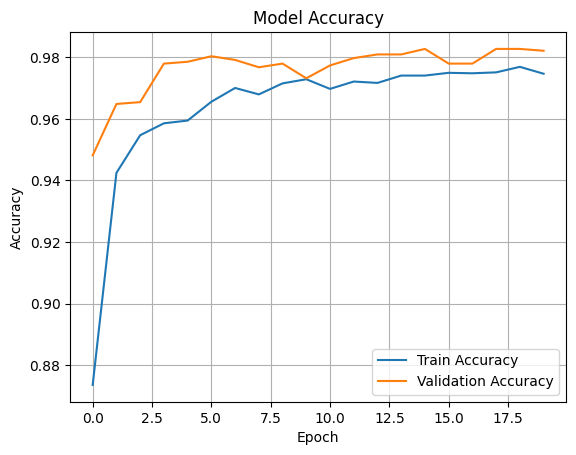

In [56]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [57]:
model.save("my_model.h5")

# **Domain Adaptation For 2015 twitter bot data!!!!**

In [58]:
import os
os.listdir()

['.config',
 'my_model_2015adapt.h5',
 'deep_model_finetuned.h5',
 'tweets.csv',
 'data',
 'friends.csv',
 '.ipynb_checkpoints',
 'users.csv',
 'followers.csv',
 'my_model.h5',
 'sample_data']

<ipython-input-61-395923e4dae0>:38: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  users_df["created_at"] = pd.to_datetime(users_df["created_at"], errors="coerce", utc=True)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9779 - loss: 0.0687 - val_accuracy: 0.9854 - val_loss: 0.0678
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9783 - loss: 0.0697 - val_accuracy: 0.9868 - val_loss: 0.0648
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9786 - loss: 0.0640 - val_accuracy: 0.9848 - val_loss: 0.0686
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9781 - loss: 0.0707 - val_accuracy: 0.9709 - val_loss: 0.0758
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9830 - loss: 0.0609 - val_accuracy: 0.9749 - val_loss: 0.0775
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9800 - loss: 0.0601 - val_accuracy: 0.9742 - val_loss: 0.0751
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9792 - loss: 0.0652 - val_accuracy: 0.9828 - val_loss: 0.0659
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9792 - loss: 0.

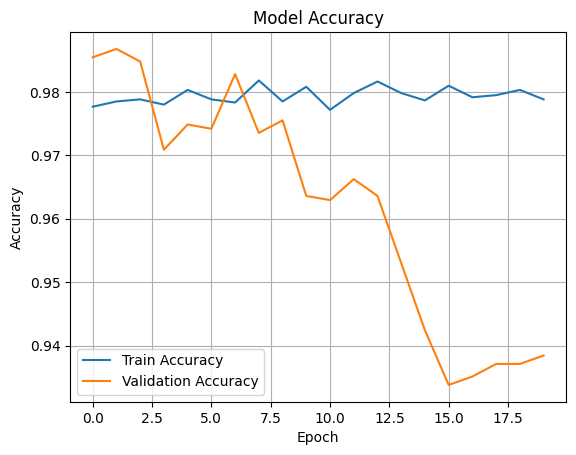

In [61]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model

# THESE ARE THE NEW 2015 DATA, Loads new domain data
users_df = pd.read_csv("users.csv")
tweets_df = pd.read_csv("tweets.csv", encoding="ISO-8859-1")
followers_df = pd.read_csv("followers.csv", encoding="ISO-8859-1")
friends_df = pd.read_csv("friends.csv", encoding="ISO-8859-1")

#Feature Engineering
#Aggregate tweet features
tweet_features = tweets_df.groupby("user_id").agg({
    "text": lambda x: x.str.len().mean(),
    "num_hashtags": "mean",
    "num_urls": "mean",
    "num_mentions": "mean",
    "retweet_count": "mean",
    "reply_count": "mean",
    "favorite_count": "mean"
}).rename(columns={
    "text": "avg_tweet_length",
    "num_hashtags": "avg_hashtags",
    "num_urls": "avg_urls",
    "num_mentions": "avg_mentions",
    "retweet_count": "avg_retweets",
    "reply_count": "avg_replies",
    "favorite_count": "avg_likes"
})

# Social graph features
follower_counts = followers_df["target_id"].value_counts().rename("total_followers")
friend_counts = friends_df["source_id"].value_counts().rename("total_following")
graph_features = pd.concat([follower_counts, friend_counts], axis=1).fillna(0)

# Clean user profile features to match original model, Merges all features with user profile data into one thing
users_df["created_at"] = pd.to_datetime(users_df["created_at"], errors="coerce", utc=True)
users_df["updated"] = pd.to_datetime(users_df["updated"], errors="coerce", utc=True)
users_df["age"] = (users_df["updated"] - users_df["created_at"]).dt.days

users_df["has_location"] = users_df["location"].notna().astype(int)
users_df["has_avatar"] = users_df["default_profile_image"].notna().astype(int)
users_df["has_background"] = users_df["profile_use_background_image"].notna().astype(int)
users_df["is_verified"] = users_df["verified"].notna().astype(int)
users_df["is_protected"] = users_df["protected"].notna().astype(int)
users_df["profile_modified"] = users_df["default_profile"].notna().astype(int)

users_df = users_df.rename(columns={
    "statuses_count": "total_tweets",
    "favourites_count": "total_likes"
})

#The MERGE
users_df = users_df.set_index("id")
merged = users_df.join(graph_features)

# Selected features out of tah 32 to use
selected_features = [
    'age', 'has_location', 'is_verified', 'total_tweets',
    'total_following', 'total_followers', 'total_likes',
    'has_avatar', 'has_background', 'is_protected'  # ←----now 10 features
]


new_domain_data = merged[selected_features].fillna(0)

# Scale and predict
scaler = StandardScaler()
X_new_scaled = scaler.fit_transform(new_domain_data)

# Load model and predict pseudo-labels
model = load_model("my_model.h5")
pseudo_probs = model.predict(X_new_scaled)
pseudo_labels = (pseudo_probs > 0.5).astype(int)

# Combine and fine-tune
X_adapted = np.vstack([X_train, X_new_scaled])
pseudo_labels = pseudo_labels.reshape(-1, 1)  # make it 2D
y_adapted = np.vstack([y_train, pseudo_labels])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_adapted, y_adapted, epochs=20, batch_size=64, validation_split=0.2)

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# Saves it
model.save("my_model_2015adapt.h5")